# Difference AGB COGs on s3  

Paul Montesano, PhD  

In [3]:
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')

import CovariateUtils
from CovariateUtils import write_cog, get_index_tile, get_shape, reader
import build_stack

# import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import geopandas as gpd
import pandas as pd
import s3fs

import rasterio
from rasterio.plot import show_hist, show

In [5]:
boreal_tiles = gpd.read_file(boreal_tile_index_path)

In [4]:
from mosaiclib import *

In [6]:
[print(var) for var in locals() if 'TINDEX_FN' in var]

ATL08_GRANULE_TINDEX_FN_DICT
ATL08_FILT_TINDEX_FN_DICT
AGB_TINDEX_FN_DICT
HT_TINDEX_FN_DICT
HLS_TINDEX_FN_DICT
SAR_TINDEX_FN_DICT
LC_TINDEX_FN_DICT
TOPO_TINDEX_FN_DICT


[None, None, None, None, None, None, None, None]

In [7]:
AGB_TINDEX_FN_DICT

{'2019_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2019/2019_fullboreal_2019lidar/AGB_tindex_master.csv',
 '2020_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2020/atl08_v6_fullboreal_min5000_90p_local/AGB_tindex_master.csv',
 '2021_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/AGB_tindex_master.csv',
 '2022_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2022/2022_fullboreal_2022lidar/AGB_tindex_master.csv',
 '2023_v1.9': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2023/2023_full_2023lidar/AGB_tindex_master.csv',
 '2020_v2.0': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master.csv'}

In [8]:
LC_TINDEX_FN_DICT

{'c2020orig': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/LC/LC_tindex_master.csv',
 'c2020updated': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/LC_tindex_master.csv'}

### Get a pair of AGB COGs from different years for a focal tile to test

In [9]:
def get_fn_pairs_list(tindex_src_fn, tindex_mask_fn, path_col, FOCAL_TILE=None):
    
    list_fn_pairs = []
    tindex_src = pd.read_csv(tindex_src_fn)
    tindex_mask = pd.read_csv(tindex_mask_fn)
    
    if FOCAL_TILE is not None:
        TILE_LIST = [FOCAL_TILE]
    else:
        TILE_LIST = tindex_src.tile_num.to_list()
        
    for FOCAL_TILE in TILE_LIST:
        src_fn = tindex_src[tindex_src.tile_num == FOCAL_TILE][path_col].to_list()[0]
        mask_fn = tindex_mask[tindex_mask.tile_num == FOCAL_TILE][path_col].to_list()[0]
        list_fn_pairs.append((src_fn, mask_fn))
    
    return list_fn_pairs      

In [10]:
FOCAL_TILE = 3457 #2686

In [ ]:
boreal_tiles[boreal_tiles.tile_num==FOCAL_TILE].explore(m=boreal_tiles.explore(), color='red')

In [14]:
t2_fn, t1_fn = get_fn_pairs_list(AGB_TINDEX_FN_DICT['2023_v1.9'], AGB_TINDEX_FN_DICT['2020_v2.0'], 's3_path', FOCAL_TILE=FOCAL_TILE)[0]

In [15]:
t2_fn

's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v5/AGB_H30_2023/2023_full_2023lidar/2024/04/07/22/06/14/152775/boreal_agb_202404071712552706_003457.tif'

In [16]:
t1_fn

's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/2024/07/17/14/21/33/086639/boreal_agb_202407171721251182_003457.tif'

In [17]:
s3_anon = s3 = s3fs.S3FileSystem(anon=True)
DIR_LOCAL = '/projects/my-public-bucket/local_output/diff_cogs'
!mkdir -p $DIR_LOCAL
s3_anon.download(t2_fn, DIR_LOCAL)

[None]

In [18]:
s3_anon.download(t2_fn, DIR_LOCAL)
s3_anon.download(t1_fn, DIR_LOCAL)

[None]

In [19]:
import importlib
importlib.reload(build_stack)

<module 'build_stack' from '/projects/code/icesat2_boreal/lib/build_stack.py'>

### Check the difference between AGB from t2 and t1

In [20]:
diff_cog_fn = build_stack.diff_cogs(os.path.join(DIR_LOCAL, os.path.basename(t2_fn)), os.path.join(DIR_LOCAL, os.path.basename(t1_fn)), FOCAL_TILE, DIR_LOCAL, diff_id_name='diff_AGB_2023_2020', bnum=1, ndv=-9999, units='mg_ha')

Opening /projects/my-public-bucket/local_output/diff_cogs/boreal_agb_202404071712552706_003457.tif
no data value is nan
Opening /projects/my-public-bucket/local_output/diff_cogs/boreal_agb_202407171721251182_003457.tif
no data value is nan
Shape of input:			 (1, 3000, 3000)
Resampling:			 0	[0=nearest, 1=blinear, 2=cubic]
Output resolution:		 (30, 30)
Writing img to memory...
Current stack shape:		(1,3000,3000)


/projects/code/icesat2_boreal/lib/build_stack.py:233: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/c19e94fb-5e76-46b3-bf58-7dd564320aa8/c19e94fb-5e76-46b3-bf58-7dd564320aa8.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/local_output/diff_cogs/diff_AGB_2023_2020_0003457.tif


Image written to disk:		 /projects/my-public-bucket/local_output/diff_cogs/diff_AGB_2023_2020_0003457.tif


### Plot

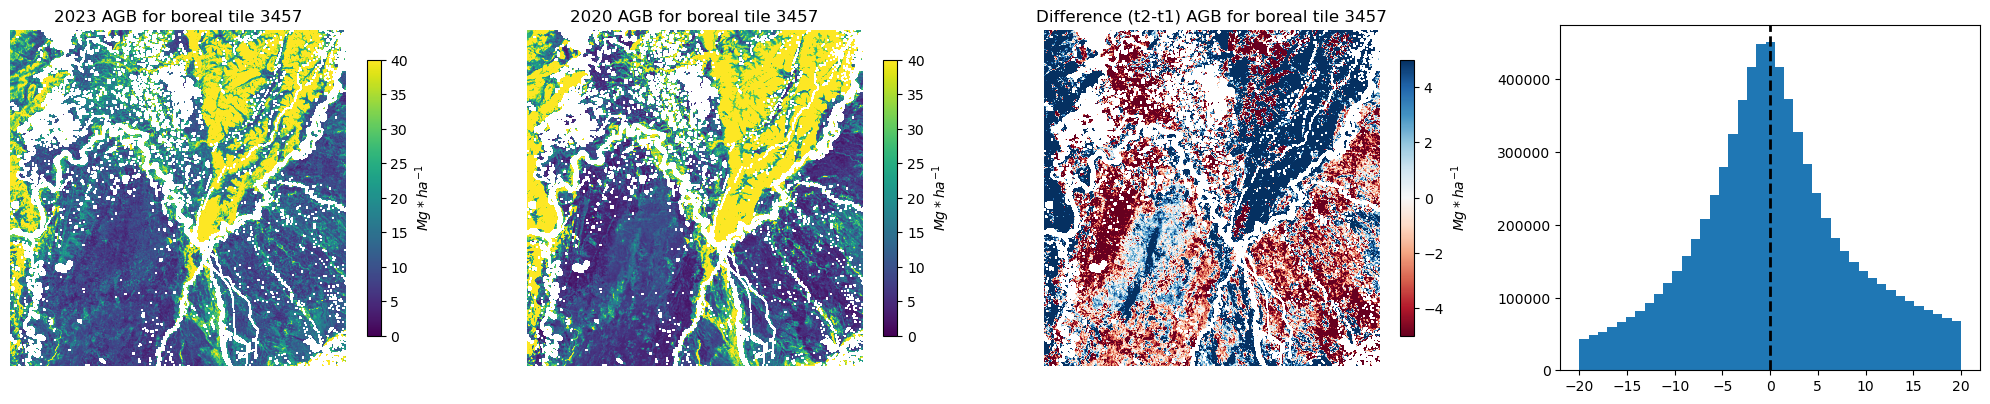

In [23]:
raster_paths = [os.path.join(DIR_LOCAL, os.path.basename(t2_fn)), os.path.join(DIR_LOCAL, os.path.basename(t1_fn)), diff_cog_fn]  # Replace with your file paths
raster_names = ['2023', '2020','Difference (t2-t1)']
CMAP_LIST = ['viridis','viridis','RdBu']
CLIM_LIST = [(0,40),(0,40),(-5,5)]
hist_kwargs = {'color': 'red'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(raster_paths)+1, figsize=(20, 4))

# If there's only one raster, ensure axes is iterable
if len(raster_paths) == 1:
    axes = [axes]

# Loop through each raster and plot it
for i, raster_path in enumerate(raster_paths):
    
    VMIN, VMAX = CLIM_LIST[i]
    CMAP = CMAP_LIST[i]
    with rasterio.open(raster_path) as src:
        # Read the first band
        arr = src.read(1)
        ax = axes[i]
        image_hidden = ax.imshow(arr, cmap=CMAP, vmax=VMAX, vmin=VMIN)
        ax.imshow(arr, cmap=CMAP, vmax=VMAX, vmin=VMIN)

        # add colorbar using the now hidden image
        cbar = fig.colorbar(image_hidden, ax=ax, shrink=0.8)
        cbar.set_label('$Mg*ha^{-1}$', rotation=90)
        
        # Add title to each subplot
        ax.set_title(f'{raster_names[i]} AGB for boreal tile {FOCAL_TILE}')
        
        # Remove axis ticks
        ax.axis('off')
        
with rasterio.open(diff_cog_fn) as ds:
    #rasterio.plot.show_hist(ds.read()[0], ax=axes[-1], bins=100, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.8)
    #axes[-1].get_legend().remove()
    axes[-1].hist(ds.read()[0].ravel(), bins=41, range=[-20, 20])
    axes[-1].axvline(x=0, color='k', linestyle='dashed', linewidth=2)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
import rioxarray as rxa
import math

In [25]:
rds_t2 = rxa.open_rasterio(t2_fn, masked=True)
valid_px_count = int(rds_t2.count().compute())
total_px_count = rds_t2.size
nodata_px_count_rds_t2 = total_px_count - valid_px_count
nodata_px_count_rds_t2

9424431

In [26]:
rds_t1 = rxa.open_rasterio(t1_fn, masked=True)
valid_px_count = int(rds_t1.count().compute())
total_px_count = rds_t1.size
nodata_px_count_rds_t1 = total_px_count - valid_px_count
nodata_px_count_rds_t1

848960

In [27]:
new_cnt_per_band = int((nodata_px_count_rds_t1-nodata_px_count_rds_t2) / rds_t2.shape[0])

print(f'T1 (relative to T2) has an additional {new_cnt_per_band} pixels ({round(new_cnt_per_band/total_px_count*100, 4)}%)')

T1 (relative to T2) has an additional -4287735 pixels (-23.8208%)


### TODO: Look in a fire polygon

In [73]:
fires_gdf = gpd.read_parquet('/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.parquet')

In [76]:
fires_tile_num_gdf = gpd.sjoin(fires_gdf, boreal_tiles.to_crs(fires_gdf.crs), op='intersects')

/opt/conda/envs/pangeo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [105]:
fire = fires_tile_num_gdf[fires_tile_num_gdf.index == 1100174].to_crs(boreal_tiles.crs) # big fire in tile 2686

In [107]:
fire.geometry.apply(lambda x: x.bounds).tolist()[0]

(3476912.8085312434,
 3873390.8745409753,
 3510187.3761930233,
 3921618.7523052315)

In [ ]:
# import rasterio
# import fiona
# from rasterstats.io import Raster

# # with fiona.open('polygon.geojson') as f:
# #     geom_bounds = f.bounds
# #     geom=f[0]['geometry']

# all_data=[]
# for tif_filename in [diff_cog_fn]:
#     with Raster(tif_filename) as raster_obj:
#         fire_bounds_list = fire.geometry.apply(lambda x: x.bounds).tolist()[0]
#         raster_subset = raster_obj.read(bounds=fire_bounds_list) 
#         polygon_mask = rasterio.features.geometry_mask(geometries=[fire.geometry],
#                                                out_shape=(raster_subset.shape[0], 
#                                                           raster_subset.shape[1]),
#                                                transform=raster_subset.affine,
#                                                all_touched=False,
#                                                invert=True)

#         #all_data.append(raster_subset.array[polygon_mask])

### MISC: Multiprocess the mask update to AGB and Height COGs on s3 

[1] Test:
    - apply this mask as a multiprocess with a write to `my-private-bucket` from within a workspace owned by Laura
         - with overwrite=False
         - with overwrite=True
         - 

In [1]:
from multiprocessing import Pool
from functools import partial

### Choose some set of raster tiles made for this project
Here, we're using a small set of test topo tiles

In [23]:
TINDEX_FN_FOR_MASK = '/projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/Topo_tindex_master.csv'

### Get the corresponding file names
#### Note: we need to use the column of the tindex that specifies the `local_path` and not the `s3_path` in order to write to subdirs of `my-private-bucket` from these notebooks

In [36]:
list_of_fn_pairs = get_fn_pairs_list(TINDEX_FN_FOR_MASK,
                                     LC_TINDEX_FN_DICT['c2020updated'], 
                                     'local_path', # here we specify the local_path column instead of the s3_path column
                                     FOCAL_TILE=3376)
list_of_fn_pairs

[('/projects/my-private-bucket/dps_output/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/2024/01/13/13/49/04/044813/CopernicusGLO30_3376_cog_topo_stack.tif',
  '/projects/my-private-bucket/dps_output/run_build_stack/build_stack_v2023/LC_ESA_WC_2020/2023/12/07/06/31/21/512416/esa_worldcover_v100_2020_3376_cog.tif')]

In [37]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(build_stack.mask_cog, mask_val_list=[60], overwrite=True ), list_of_fn_pairs)

\mask_arr shape: (3000, 3000)
Shape of input:			 (5, 3000, 3000)
Input nodata isnt provided; assuming NaN...
Resampling:			 0	[0=nearest, 1=blinear, 2=cubic]
Output resolution:		 (30, 30)
Writing img to memory...


/projects/code/icesat2_boreal/lib/build_stack.py:157: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  write_cog(


Current stack shape:		(5,3000,3000)


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/7505f97c-ad9e-4d4a-a555-79b39b7c2b41/7505f97c-ad9e-4d4a-a555-79b39b7c2b41.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-private-bucket/dps_output/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/2024/01/13/13/49/04/044813/CopernicusGLO30_3376_cog_topo_stack.tif


Image written to disk:		 /projects/my-private-bucket/dps_output/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/2024/01/13/13/49/04/044813/CopernicusGLO30_3376_cog_topo_stack.tif


In [38]:
%%time
USER = 'montesano'
ALG_NAME = 'run_build_stack_topo'
ALG_VERSION = 'build_stack_v2023_2'
IDENTIFIER = 'CopernicusGLO30_TEST'
TYPE = 'Topo'


DPS_IDENTIFIER = f"{ALG_VERSION}/{IDENTIFIER}"
DPS_MONTH_LIST = '01'   
DPS_YEAR_LIST = '2024'

DPS_DAY_MIN = 1
OUTDIR = f"/projects/my-public-bucket/DPS_tile_lists/{ALG_NAME}/{DPS_IDENTIFIER}"
!mkdir -p $OUTDIR

# Build tindex
args = f"--RETURN_DUPS \
--user {USER} \
--dps_identifier {DPS_IDENTIFIER} \
-alg_name {ALG_NAME} \
-t {TYPE} \
-y_list {DPS_YEAR_LIST} \
--dps_month_list {DPS_MONTH_LIST} \
-d_min {DPS_DAY_MIN} \
--outdir {OUTDIR}"

!time /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_tindex_master.py $args --WRITE_TINDEX_MATCHES_GDF

NASA MAAP
INFO: Pandarallel will run on 25 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
NASA MAAP

Building a list of tiles:
DPS ID:		build_stack_v2023_2/CopernicusGLO30_TEST
Type:		Topo
Year:		['2024']
Month:		['01']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST
# of duplicate tiles: 1
Final # of tiles: 10
Writing duplicates csv: /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/Topo_tindex_master_duplicates.csv
Writing tindex master csv: /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30_TEST/Topo_tindex_master.csv
Building geodataframe of matches, tindex master json, and mosaic json...
Tile index matches geodataframe for json: (10, 7)
Building /projects/my-public-bucket/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusG